# Forecasting absolute returns with NN

In [5]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [6]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [7]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
file_path = os.path.join(notebook_dir, "Model_testing_daily/input_data_daily.csv")
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])  # ADD THIS LINE
data = data.set_index("Date")

In [8]:
data["absolute_return"] = data["DailyReturn"].abs()

In [9]:
# Feature matrix (same features as sign model)
features = np.column_stack([
    data['Realized_Vol_5d'].values,
    data['Realized_Vol_20d'].values,
    data['Return_Lag1'].values,
    data['Volume_change'].values,
    data['Trading_range'].values,
    data['ten_y_tnotes'].values,
    data['three_months_tbills'].values,
    data['oil_price_return'].values,
    data['vix_index'].values,
    data['vix_return'].values
])

# Drop NaN rows
data_clean = data.dropna()
features_clean = features[~np.isnan(features).any(axis=1)]

### Create lagged sequences

In [10]:
NUMBER_OF_LAGS = 60

def create_lagged_matrix(X, window):
    """Create lagged sequences for time series."""
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix(features_clean, NUMBER_OF_LAGS)
y_target = data_clean['absolute_return'].values[NUMBER_OF_LAGS:]
dates_lagged = data_clean.index[NUMBER_OF_LAGS:]

print(f"X_lagged shape: {X_lagged.shape}")
print(f"y_target shape: {y_target.shape}")

X_lagged shape: (3519, 60, 10)
y_target shape: (3519,)


## Models

In [11]:
# Define LSTM model for regression
class AbsReturnLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(AbsReturnLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last timestep
        return self.fc(out)  # No activation - linear output for regression

# Define GRU model for regression
class AbsReturnGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(AbsReturnGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, 
                         batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

In [12]:
NUM_LAYERS = 2
HIDDEN_DIM = 64
EPOCHS = 100
BATCH_SIZE = 64
LR = 0.001
DROPOUT = 0.1

In [13]:
dates_lagged = data.index[NUMBER_OF_LAGS:] 
years = dates_lagged.year
unique_years = np.unique(years).astype(int)
min_year = int(unique_years.min())
max_year = int(unique_years.max())

# require at least this many trading observations for a year to be considered "full"
MIN_DAYS_PER_YEAR = 200

# find first test_year such that test_year and previous 3 years each have >= MIN_DAYS_PER_YEAR samples
first_valid_test_year = None
for cand in range(min_year + 3, max_year + 1):
    train_years = [cand - 3, cand - 2, cand - 1]
    counts = {y: np.sum(years == y) for y in train_years + [cand]}
    if all(counts[y] >= MIN_DAYS_PER_YEAR for y in train_years + [cand]):
        first_valid_test_year = cand
        print("First valid test year:", first_valid_test_year)
        break

if first_valid_test_year is None:
    raise RuntimeError("No calendar-aligned test year found with sufficient data. Lower MIN_DAYS_PER_YEAR or check your date range.")

First valid test year: 2004


yearly rolling window:   0%|          | 0/11 [00:00<?, ?it/s]

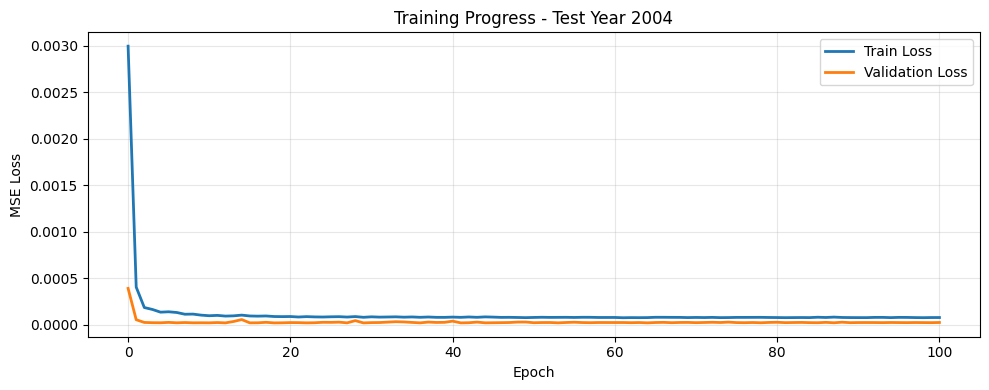

yearly rolling window:   9%|▉         | 1/11 [00:24<04:06, 24.69s/it]

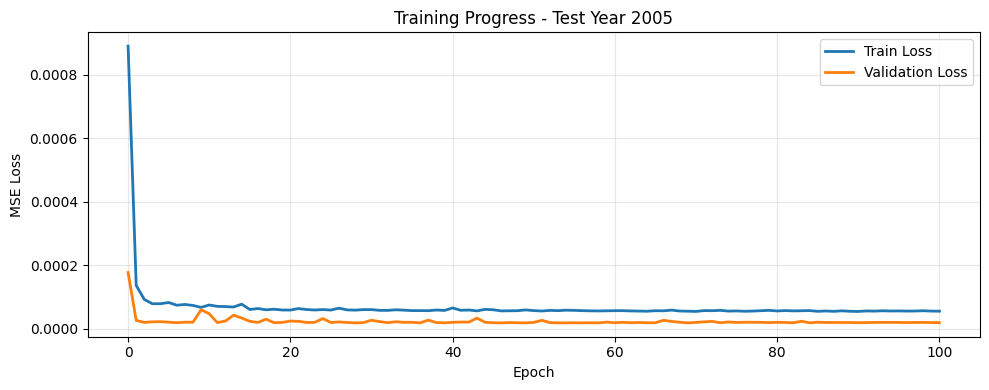

yearly rolling window:  18%|█▊        | 2/11 [00:43<03:09, 21.07s/it]

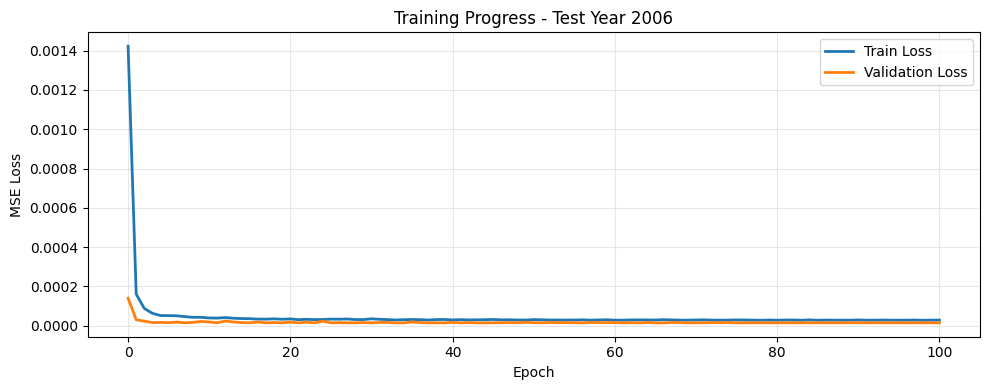

yearly rolling window:  27%|██▋       | 3/11 [00:59<02:30, 18.86s/it]

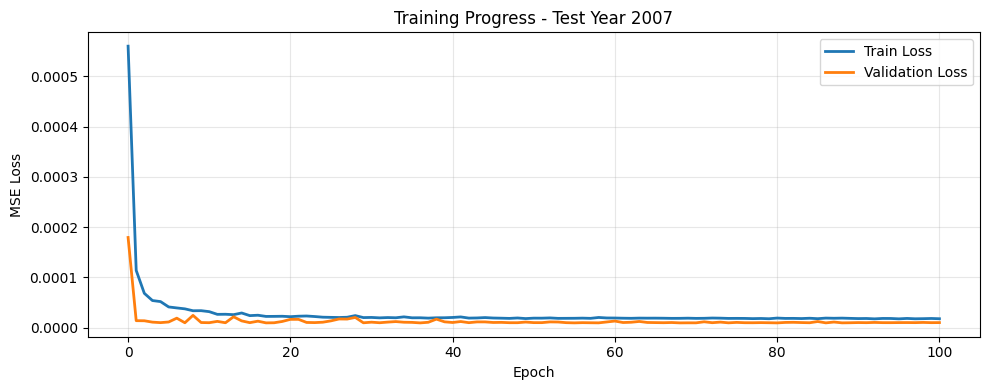

yearly rolling window:  36%|███▋      | 4/11 [01:16<02:07, 18.23s/it]

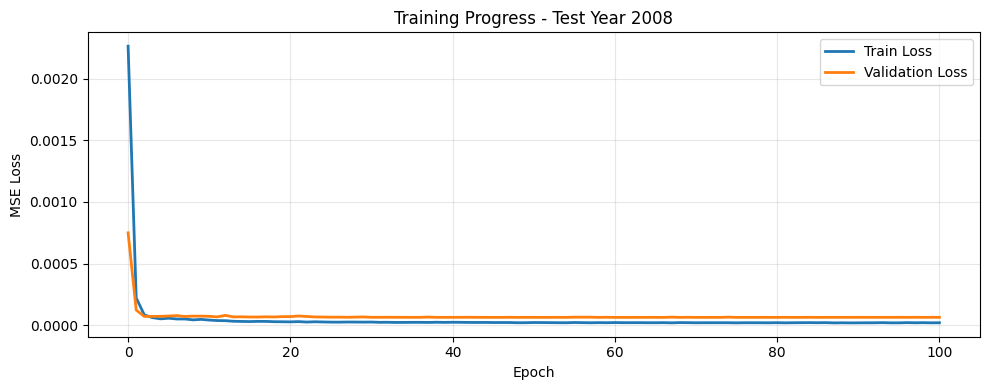

yearly rolling window:  45%|████▌     | 5/11 [01:33<01:45, 17.63s/it]

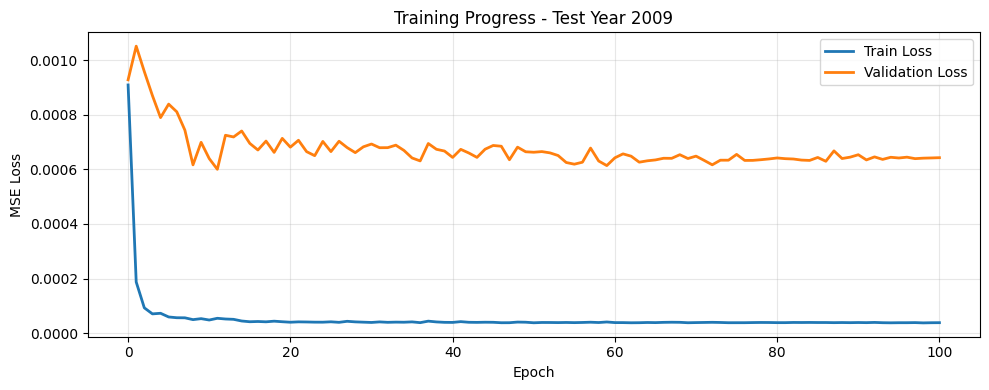

yearly rolling window:  55%|█████▍    | 6/11 [01:54<01:34, 18.88s/it]

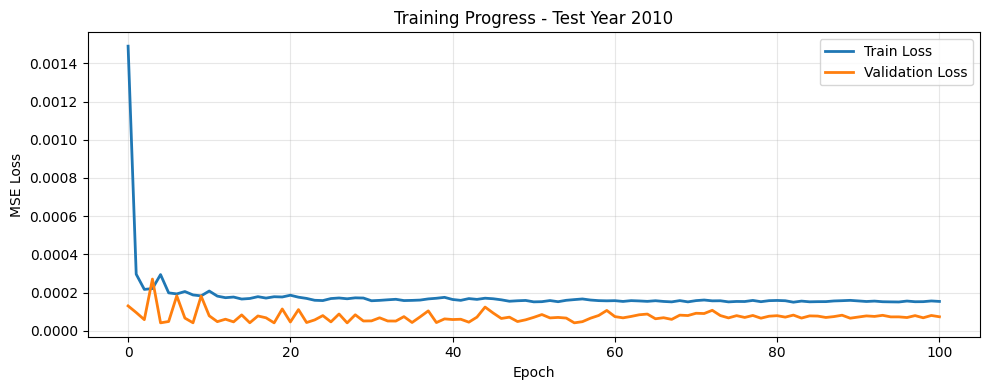

yearly rolling window:  64%|██████▎   | 7/11 [02:15<01:18, 19.59s/it]

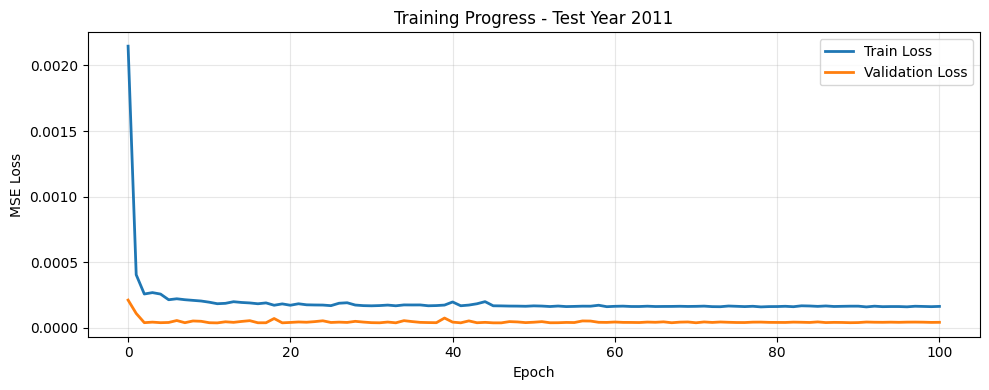

yearly rolling window:  73%|███████▎  | 8/11 [02:37<01:01, 20.34s/it]

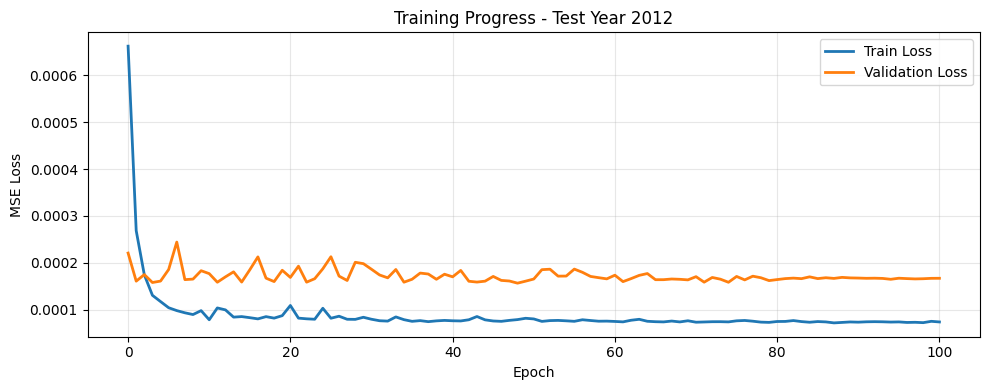

yearly rolling window:  82%|████████▏ | 9/11 [02:58<00:41, 20.64s/it]

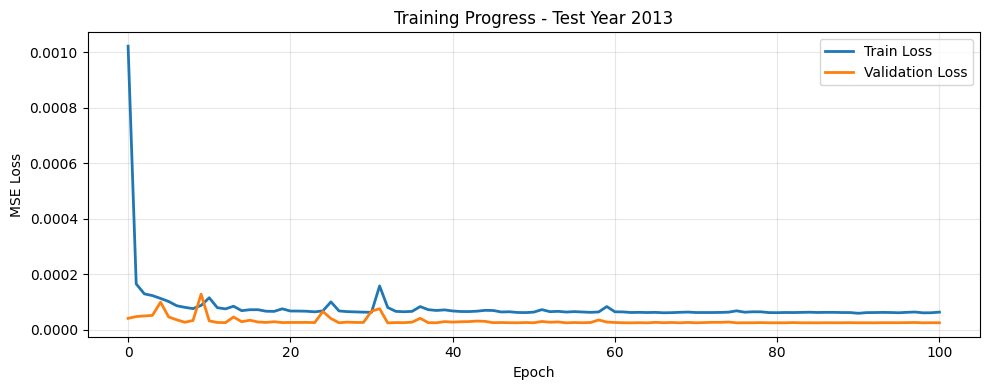

yearly rolling window:  91%|█████████ | 10/11 [03:19<00:20, 20.77s/it]

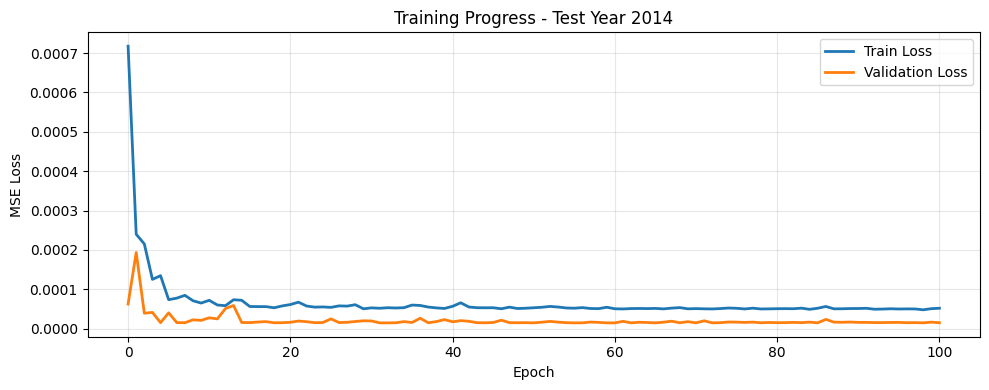

yearly rolling window: 100%|██████████| 11/11 [03:41<00:00, 20.15s/it]


In [14]:
from tqdm import tqdm

window_results = []
window_no = 0

for test_year in tqdm(range(first_valid_test_year, max_year+1), desc="yearly rolling window"):
    window_no += 1
    train_years = [test_year - 3, test_year - 2, test_year - 1]
    train_idx = np.where(np.isin(years, train_years))[0]
    test_idx  = np.where(years == test_year)[0]

    if len(train_idx) < 700 or len(test_idx) < 230:
        raise ValueError("The data length suggests there is insufficient data in window {}.".format(window_no))

    # Split train into train/val (85/15 split)
    val_size = int(len(train_idx) * 0.15)
    train_idx_split = train_idx[:-val_size]
    val_idx = train_idx[-val_size:]

    # prepare split
    X_tr = X_lagged[train_idx_split]
    y_tr = y_target[train_idx_split]
    X_val = X_lagged[val_idx]
    y_val = y_target[val_idx]
    X_te = X_lagged[test_idx]
    y_te = y_target[test_idx]
    input_dim = X_tr.shape[2]

    # tensors
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr.reshape(-1,1), dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)
    X_te_t = torch.tensor(X_te, dtype=torch.float32)

    # new model per window
    model_window = AbsReturnLSTM(input_dim=input_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
    optimizer = optim.Adam(model_window.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
    criterion = nn.MSELoss()

    ds = TensorDataset(X_tr_t, y_tr_t)
    data_loader = DataLoader(ds, batch_size=32, shuffle=True)

    # Track losses
    train_losses = []
    val_losses = []

    # train
    for epoch in range(EPOCHS+1):
        model_window.train()
        epoch_loss = 0.0
        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()
            pred = model_window(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        
        train_loss = epoch_loss / len(X_tr_t)
        train_losses.append(train_loss)
        
        # Validation loss
        model_window.eval()
        with torch.no_grad():
            val_pred = model_window(X_val_t)
            val_loss = criterion(val_pred, y_val_t).item()
        val_losses.append(val_loss)
        
        scheduler.step()

    # Plot train/val loss for this window
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Training Progress - Test Year {test_year}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # predict for the whole test year
    model_window.eval()
    with torch.no_grad():
        y_pred = model_window(X_te_t).numpy() 
    mse = mean_squared_error(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)

    # Save results
    train_start_date = dates_lagged[train_idx[0]].date()
    train_end_date   = dates_lagged[train_idx[-1]].date()
    test_start_date  = dates_lagged[test_idx[0]].date()
    test_end_date    = dates_lagged[test_idx[-1]].date()

    window_df = pd.DataFrame({
        'Actual_Value': y_te,
        'Predicted_Value': y_pred.flatten(),
        'MSE': mse,
        'MAE': mae,
        'Train_Start': train_start_date,
        'Train_End': train_end_date,
        'Test_Start': test_start_date,
        'Test_End': test_end_date
    }, index=dates_lagged[test_idx])

    window_results.append(window_df)

# combine windows
if window_results:
    rolling_results = pd.concat(window_results).sort_index()
else:
    print("No windows produced - check TRAIN_DAYS/TEST_DAYS and data length.")

In [15]:
rolling_results.describe()

,Actual_Value,Predicted_Value,MSE,MAE
count,2753.000000,2753.000000,2753.000000,2753.000000
mean,0.007955,0.007888,0.000076,0.005543
std,0.009631,0.004086,0.000094,0.002613
min,0.000000,0.000133,0.000016,0.002999
25%,0.002181,0.005057,0.000019,0.003444
50%,0.005094,0.006792,0.000029,0.004067
75%,0.010213,0.009576,0.000102,0.007447
max,0.109572,0.036351,0.000348,0.011676


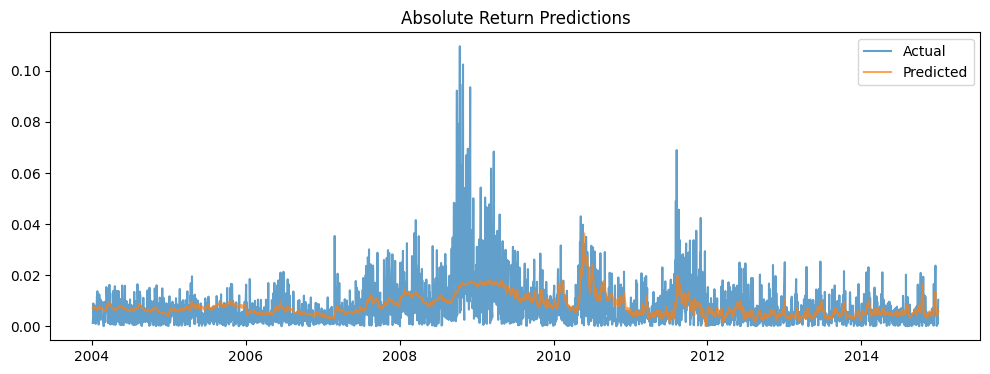

In [16]:
# Plot predictions vs actual
plt.figure(figsize=(12, 4))
plt.plot(rolling_results['Actual_Value'], label='Actual', alpha=0.7)
plt.plot(rolling_results['Predicted_Value'], label='Predicted', alpha=0.7)
plt.legend()
plt.title('Absolute Return Predictions')
plt.show()

## Bringing individual components (sign and absolute values) together

In [19]:
sign_preds = pd.read_csv(os.path.join(notebook_dir, "LSTM_rolling_annual_results.csv"), parse_dates=['Date'], index_col='Date')["Predicted_Sign"]
sign_preds = np.where(sign_preds > 0, 1, -1)
absolute_preds = rolling_results["Predicted_Value"]
combined_preds = sign_preds * absolute_preds

In [20]:
combined_preds.describe()

count    2753.000000
mean        0.004575
std         0.007616
min        -0.017896
25%         0.004140
50%         0.006025
75%         0.008170
max         0.036351
Name: Predicted_Value, dtype: float64

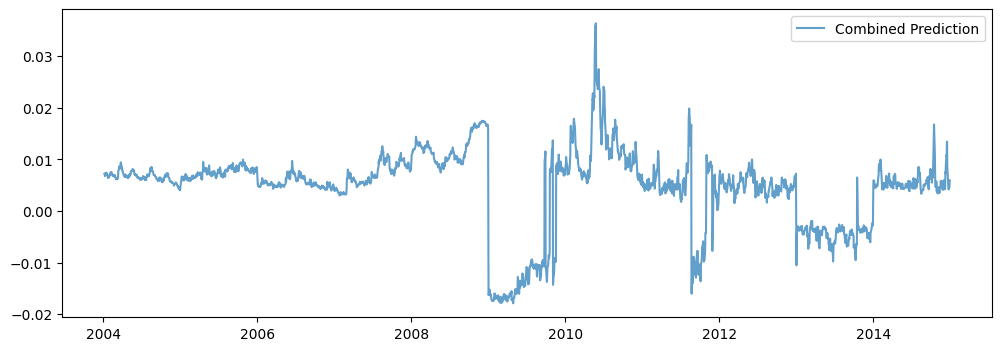

In [23]:
# plot combined predictions vs actual
plt.figure(figsize=(12, 4))
plt.plot(combined_preds, label='Combined Prediction', alpha=0.7)
plt.legend()